In [1]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
path = Path('/home/qiao/dev/giao/datasets/M300S/')

path_img = path/'S_kaggle_wildfire/'
path_label = path/'S_kaggle_wildfire_label'
codes = ['Smoke', 'Flame', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/M300S/S_kaggle_wildfire')

In [5]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/datasets/M300S/S_kaggle_wildfire/000366.jpg


In [6]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/datasets/M300S/S_kaggle_wildfire_label/label_000373.jpg


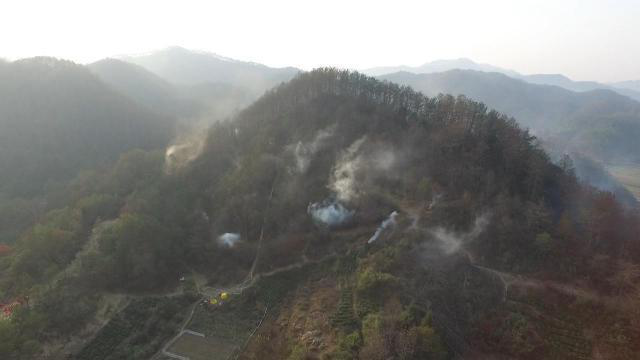

In [7]:
img = Image.open(fnames[0])
img.show()

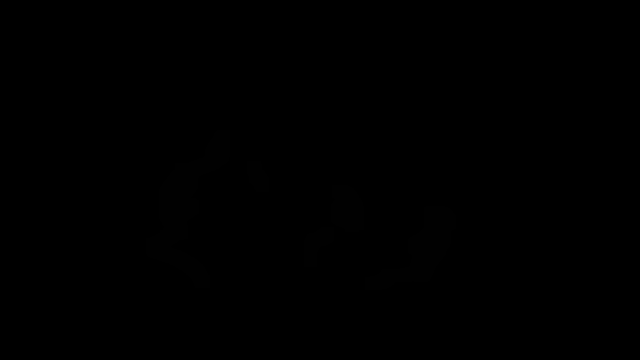

In [8]:
img = Image.open(lbl_names[0])
img.show()

In [9]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

In [10]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [12]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(valley=0.00019054606673307717)

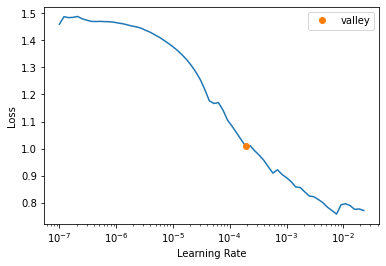

In [14]:
learn.lr_find()

In [15]:
lr = 1.9e-4
learn.fit_one_cycle(50, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,0.342848,0.216241,0.928993,01:46
1,0.195562,0.169847,0.937171,01:44
2,0.154319,0.130013,0.950733,01:44
3,0.147017,0.118201,0.952597,01:43
4,0.127342,0.114259,0.952082,01:44
5,0.123442,0.146401,0.943115,01:44
6,0.107133,0.121514,0.951866,01:44
7,0.110545,0.121466,0.948314,01:44
8,0.107548,0.130073,0.938541,01:44
9,0.097129,0.096723,0.959554,01:44


/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


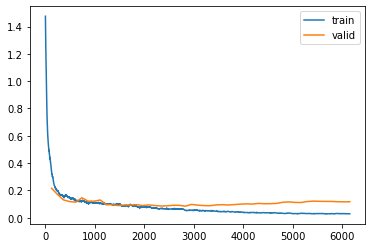

In [16]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [17]:
learn.save('stage-1')
learn.load('stage-1')

SuggestedLRs(valley=2.0892961401841603e-05)

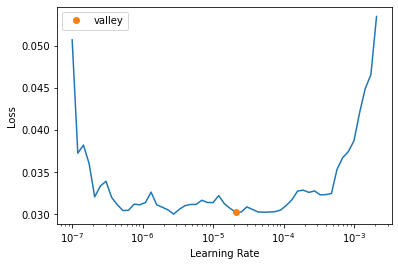

In [18]:
learn.unfreeze()
learn.lr_find()

In [19]:
lr_max = 2e-5

In [20]:
learn.fit_one_cycle(6, lr_max)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.029806,0.120625,0.967504,01:50
1,0.031108,0.107826,0.966785,01:50
2,0.032107,0.118499,0.965886,01:49
3,0.029349,0.121182,0.966985,01:49
4,0.028182,0.120589,0.967060,01:49
5,0.027521,0.119608,0.967007,01:49


/home/qiao/anaconda3/envs/dev/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


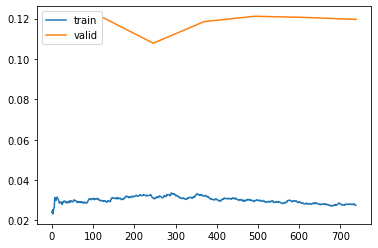

In [21]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/M300S/S_kaggle_wildfire/models/U-res34.pth')

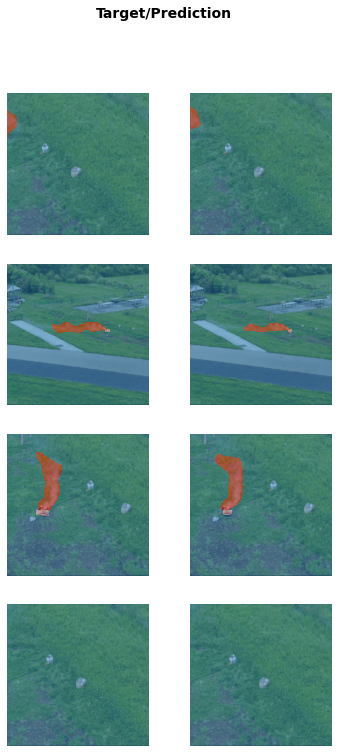

In [22]:
learn.show_results()
learn.save('U-res34')

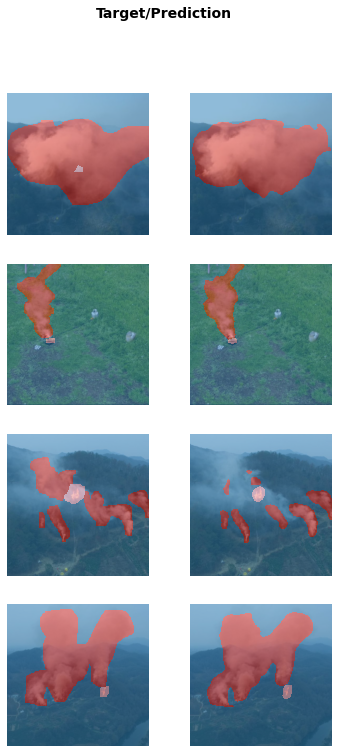

In [24]:
# learn.show_results()
learn.load('U-res34')
learn.show_results()

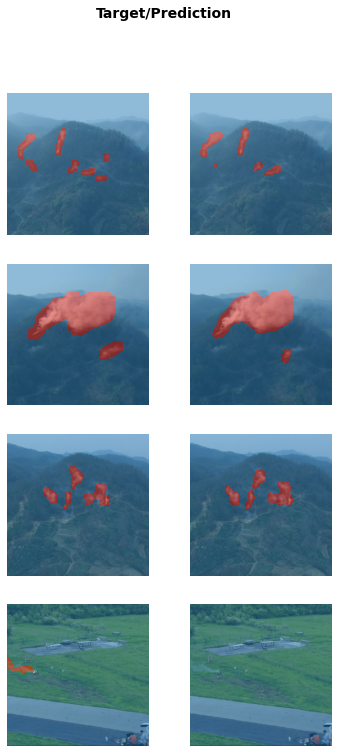

In [25]:
learn.show_results()

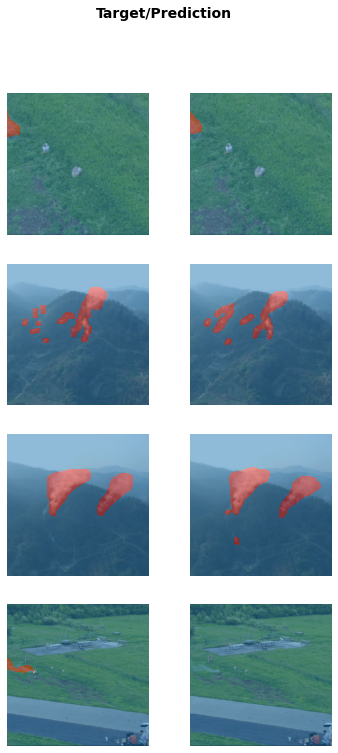

In [26]:
learn.show_results()

In [27]:
# learn.show_results()
# learn.save('alunet')

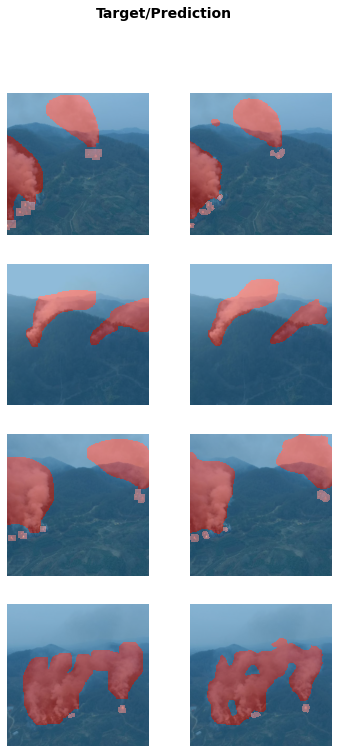

In [28]:
learn.show_results()

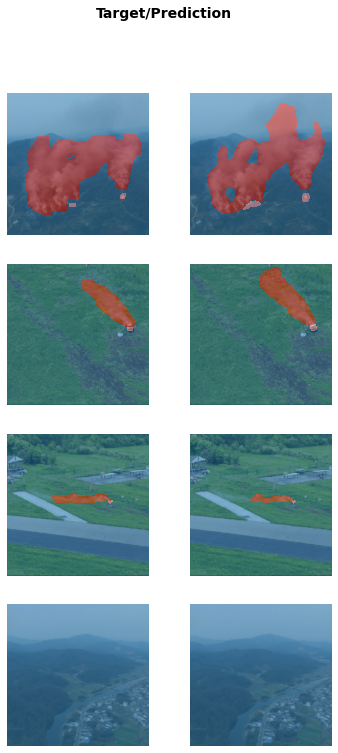

In [29]:
learn.show_results()

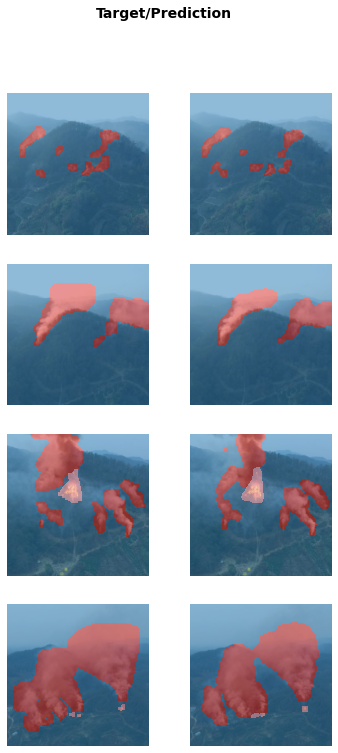

In [30]:
learn.show_results()

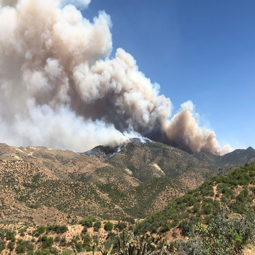

In [31]:
img = Image.open('/home/qiao/dev/giao/datasets/S_google_wildfire/004.png').resize((255, 255))
img.show()

In [32]:
img = PILImage(img)
print(img)

PILImage mode=RGB size=255x255


In [33]:
learn.load('U-res34')
# learn.load('attunet')

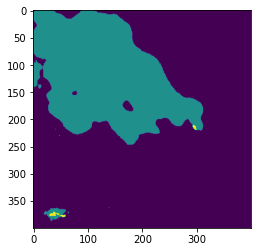

In [34]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

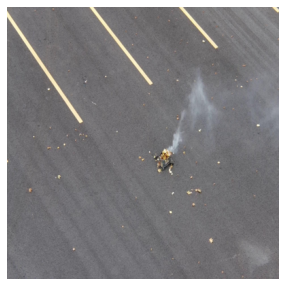

In [35]:
# one time test
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/bounding/images/DJI_20211017111122_0003_Z_MP4_1.png')

# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pilimgimg = Image.fromarray(img).resize((400, 400))
img_pil = PILImage(im_pilimgimg)
img_pil.show()

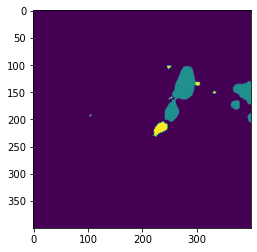

In [36]:
prediction_mask = learn.predict(img_pil)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)